# 智慧運算技術導論 (Week 4 自然語言處理主題 - Day1)
今日教學內容：
- TF-IDF
- Word embeddings

In [ ]:
!pip install datasets wordcloud

## TF-IDF

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud

In [ ]:
# 載入 PubMed 20k RCT 資料集 (只取訓練集的前 2000 句以求快速)
dataset = load_dataset("armanc/pubmed-rct20k", split="train[:2000]")

# 轉換成 Pandas DataFrame 比較好處理以及觀察資料
df = pd.DataFrame(dataset)

# 看一下資料長什麼樣子 (Label 0-4 代表不同段落)
print(f"資料筆數: {len(df)}")
df[['text', 'label']].head(10)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Repo card metadata block was not found. Setting CardData to empty.


資料筆數: 2000


,text,label
0,To investigate the efficacy of @ weeks of dail...,objective
1,A total of @ patients with primary knee OA wer...,methods
2,Outcome measures included pain reduction and i...,methods
3,Pain was assessed using the visual analog pain...,methods
4,Secondary outcome measures included the Wester...,methods
5,"Serum levels of interleukin @ ( IL-@ ) , IL-@ ...",methods
6,There was a clinically relevant reduction in t...,results
7,The mean difference between treatment arms ( @...,results
8,"Further , there was a clinically relevant redu...",results
9,These differences remained significant at @ we...,results


In [ ]:
# @title 2. 計算 TF-IDF 權重
# stop_words='english' 會自動過濾掉 the, is, at 這種無意義字

corpus = df['text'].tolist()
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(corpus)

# 取得字的名稱（`feature_names`）
feature_names = vectorizer.get_feature_names_out()
# 轉成 DataFrame 方便觀察
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
# 將每個字的分數對不同句子進行加總
total_word_weights = df_tfidf.sum(axis=0) # axis=0 為垂直加總

print("--- 全資料集 TF-IDF 最高的字 ---")
print(total_word_weights.sort_values(ascending=False).head(10))

--- 全資料集 TF-IDF 最高的字 ---
group            58.777334
patients         53.443522
treatment        35.455767
study            30.204629
groups           28.775957
randomized       25.672156
trial            25.271546
significant      23.909276
control          23.864684
significantly    22.303422
dtype: float64


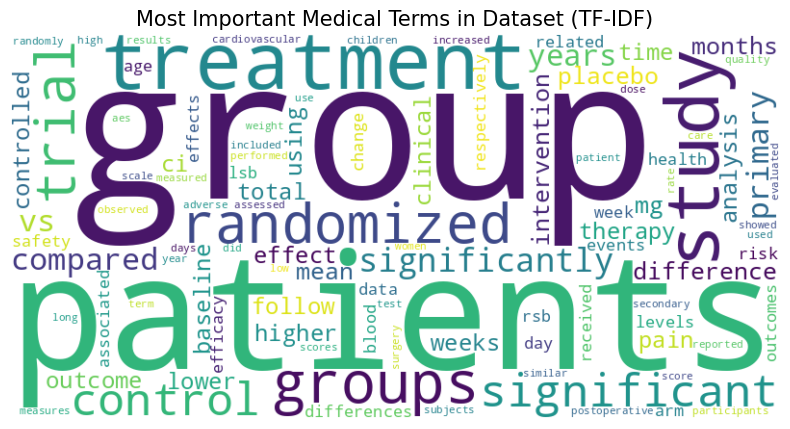

In [ ]:
# @title 3. 畫出醫療文字雲 (視覺化)

# 1. 準備資料
# WordCloud 需要的輸入格式是字典： {'word': weight, ...}
# 我們直接把上一格算出來的 total_word_weights 轉成字典即可
word_weights = total_word_weights.to_dict()

# 2. 產生文字雲
# generate_from_frequencies 專門用來處理已經算好權重的資料
wc = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',  # 配色方案，也可以改用 'Blues' 或 'plasma'
    max_words=100        # 只顯示權重最高的前 100 個字，避免太雜
).generate_from_frequencies(word_weights)

# 3. 繪圖
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off") # 關閉座標軸
plt.title("Most Important Medical Terms in Dataset (TF-IDF)", fontsize=15)
plt.show()

In [ ]:
# @title 4-1. 實作：簡易醫學文獻搜尋引擎

def search_engine(query: str, top_k: int = 3):
    # 把使用者的 Query 也變成 TF-IDF 向量
    query_vec = vectorizer.transform([query])

    # 計算 Query 向量跟資料庫所有向量的「餘弦相似度 (Cosine Similarity)」
    # 結果會是一個分數列表，範圍 0 (完全不相關) ~ 1 (一模一樣)
    similarity_scores = cosine_similarity(query_vec, tfidf_matrix).flatten()

    # 找出分數最高的 top_k 個句子的索引
    # argsort 會從小排到大，所以我們要取最後 k 個並反轉（反轉使用[::-1]）
    top_indices = similarity_scores.argsort()[-top_k:][::-1]

    print(f"🔎 您的查詢: {query}")
    print("-" * 50)

    for i, idx in enumerate(top_indices):
        score = similarity_scores[idx]
        if score > 0: # 只顯示有相關的
            print(f"🏆 第 {i+1} 名 (相似度: {score:.4f})")
            print(f"   原文: {corpus[idx]}")
            print()
        else:
            print("沒有找到相關的句子。")

In [ ]:
# @title 4-2. 執行搜尋（你可以改改看 `query`！）

search_engine(query="pain relief for patients")

🔎 您的查詢: pain relief for patients
--------------------------------------------------
🏆 第 1 名 (相似度: 0.6665)
   原文: For who actually received pain relief the area under the curve for satisfaction with pain relief after the start of pain relief was @ in the remifentanil group versus @ in the epidural analgesia group ( mean difference -@ , -@ to -@ ) .

🏆 第 2 名 (相似度: 0.4975)
   原文: At the end of the follow-up , the leg pain relief was statistically significant for both groups .

🏆 第 3 名 (相似度: 0.4639)
   原文: Before the onset of active labour consenting women were randomised to a pain relief strategy with patient controlled remifentanil or epidural analgesia if they requested pain relief during labour .



## Word Embeddings

In [ ]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 44.7 MB/s eta 0:00:00


In [ ]:
# @title 5. Word Embeddings：載入預訓練詞向量 (GloVe 50d，下載小、速度快)

import re
import numpy as np
import gensim.downloader as api
from sklearn.metrics.pairwise import cosine_similarity

# 下載並載入預訓練詞向量（glove-wiki-gigaword-50 約 70MB，Colab 通常可接受）
wv = api.load("glove-wiki-gigaword-50")

In [ ]:
print("✅ 載入完成：glove-wiki-gigaword-50")
print("向量維度 (embedding dim):", wv.vector_size)
print("詞彙量 (vocab size):", len(wv.key_to_index))

✅ 載入完成：glove-wiki-gigaword-50
向量維度 (embedding dim): 50
詞彙量 (vocab size): 400000


In [ ]:
# @title 6. 看看單一詞的 embedding 向量「形狀、內容」

word = "pain"  # 👈 可以改這個字，例如 "fever", "cancer", "patient"

if word in wv:
    v = wv[word]
    print(f"\n🧠 '{word}' 的 embedding：")
    print("shape:", v.shape)
    print("dtype:", v.dtype)
    print("前 10 個數值:", np.round(v[:10], 4))


🧠 'pain' 的 embedding：
shape: (50,)
dtype: float32
前 10 個數值: [ 0.6404  0.0958 -0.7365 -0.9176 -0.2736  1.0466  1.2716  0.9891  0.6023
  0.7958]


In [ ]:
# @title 7. 找語意相近的詞

word = "pain"  # 👈 可以改這個字，例如 "fever", "cancer", "patient"
topn = 5       # 👈 可以改要印出前幾相近的詞

word = word.lower()
if word not in wv:
    print(f"⚠️ '{word}' OOV（不在詞向量裡）")
else:
    print(f"\n🔎 與 '{word}' 最相近的 {topn} 個詞：")
    for ww, score in wv.most_similar(word, topn=topn):
        print(f"  {ww:15s}  {score:.3f}")


🔎 與 'pain' 最相近的 5 個詞：
  suffering        0.852
  stress           0.840
  pains            0.838
  stomach          0.836
  heart            0.827


In [ ]:
# @title 8. 兩個詞的相似度（cosine similarity）

w1, w2 = "pain", "fever"  # 👈 可改成 "cancer" vs "tumor" 等

w1, w2 = w1.lower(), w2.lower()
if (w1 in wv) and (w2 in wv):
    sim = float(wv.similarity(w1, w2))
    print(f"\n📏 cosine similarity('{w1}', '{w2}') = {sim:.3f}")
else:
    print("⚠️ 輸入有字不在詞向量字典中（out-of-vocabulary）：", w1, w2)


📏 cosine similarity('pain', 'fever') = 0.658


In [ ]:
# @title 9. 字詞類比（word analogy）
a, b, c = "man", "woman", "king"  # 👈 可改成 "doctor", "hospital", "teacher" 等

a, b, c = a.lower(), b.lower(), c.lower()
missing = [w for w in [a, b, c] if w not in wv]
if missing:
    print("⚠️ 這些字不在詞向量字典中（OOV）：", missing)
    print("建議先用較常見的英文字：man/woman/king/queen, doctor/nurse, paris/france ...")
else:
    print(f"🧩 類比題：{a} : {b} = {c} : ?")
    # positive=[b, c], negative=[a] 代表 b + c - a
    for w, s in wv.most_similar(positive=[b, c], negative=[a], topn=topn):
        print(f"  {w:15s}  {s:.3f}")

🧩 類比題：doctor : hospital = teacher : ?
  school           0.802
  attended         0.752
  elementary       0.745
  campus           0.741
  nursing          0.734
